# Sampling and the law of large numbers

We saw how probability distributions can be used in Monte Carlo simulation. In this notebook, we see how they can be used to sample data: Sampling is a fundamental process in the collection of data. Sampling is important because we can almost never look at the whole population. Some key points to keep in mind about sampling are:

- An understanding of sampling is essential to ensure that analyses performed are representative of the entire population. 
- You will use **inference** on the sample to say something about the population.
- You will need estimates of variances on the sample calculations to say something about the population.

Let's look at some examples of sampling.

| use case | sample | population |
|---|---|---|
| A/B Testing | users we show either web sites A or B | all possible users, past present and future |
| World Cup | 32 teams which qualify in one season | all national teams in past, present and future years |
| average height of data science students | students in UW data science program | all students taking data science classes world wide |

Notice, that in several cases it is not only impractical, but impossible to collect data from the entire population. Hence, we must work with correctly collected samples. 

At the conclusion of this lesson, you should be able to apply a number of commonly used sampling strategies: 

- Bernoulli sampling
- stratified sampling
- cluster sampling
- systematic sampling

In [1]:
import numpy.random as nr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Let's first generate a dataset that we will use to draw samples from later. The data has a single numeric variable generated from a standard normal distribution and a grouping variable called `group` with 4 groups and another grouping variable called `cluster` which we use to illustrate the difference between various sampling strategies.

In [2]:
nr.seed(345)
nrows = 200

data = pd.DataFrame({"var": nr.normal(size = nrows), 
                     "group": nr.choice(range(4), size = nrows, p = [0.1,0.3,0.4,0.2]),
                     "cluster": nr.choice(range(10), size = nrows)})
data.head()

,var,group,cluster
0,1.469248,1,0
1,-1.150144,1,7
2,2.519226,0,9
3,-0.082478,1,6
4,-0.033601,1,2


Here's a breakdown showing the average for `var` and frequencies and relative frequencies in each group.

In [3]:
def mean_count(df, by = 'group'):
    res = df.groupby(by).agg({'var':['mean', 'count']})
    res.loc[:, ('var', 'pct')] = df[by].value_counts(normalize = True)
    return res

mean_count(data)

var            
           mean count   pct
group                      
0     -0.016270    24  0.12
1      0.033306    62  0.31
2      0.051564    68  0.34
3     -0.170043    46  0.23

In the remainder of the notebook, we may occasionally refer to this data as the **population**.

## Simple random sample

A **simple random sample (SRS)** is probably the most common way to sample data. The sample size is fixed and every  data point has the same probability of ending up in the sample. There are many ways to create a simple random sample from data.

In [4]:
sample_srs = data.sample(n = 10)
sample_srs.head()

,var,group,cluster
1,-1.150144,1,7
40,0.364391,2,9
168,0.649762,2,4
167,0.145883,3,6
156,-0.937419,2,5


In [5]:
sample_srs = data.sample(frac = 0.05)
sample_srs.head()

,var,group,cluster
14,-0.232576,1,2
175,0.709961,2,3
184,-0.362807,1,7
146,-0.879824,3,3
15,0.379893,1,9


## Bernoulli sampling

A Bernoulli sample is a sample where all population members have equal an chance of being selected. A Bernoulli sample is very similar to SRS, with the distinction that in an SRS the sample size is usually fixed but in a Bernoulli sample it can change.

An example would be to randomly sample products in a factory to ensure quality.
Let's look at an example. The code in the cell below creates a 200 random samples of a normal distribution, divided into 4 groups.

Next, we take a Bernoulli sample of the data:

In [6]:
p = 0.10 # percent of the data to sample

sample_bern = data.loc[nr.binomial(1, p, size = 200) == 1, :]
mean_count(sample_bern)

var                
           mean count       pct
group                          
0      1.335569     4  0.181818
1     -0.481447     5  0.227273
2      0.486400     8  0.363636
3     -0.245271     5  0.227273

You can see that each group in the sample is represented in approximately the same proportion as in the population.

### Exercise

Here's another ways to create a Bernoulli sample: Generate a random uniform number from $0$ to $1$ for each row of the data and select the row only if the number generated is belween $0$ and $p$. Implement such a solution.

In [7]:
p = .10
u = np.random.uniform(size = 200)
sample_u = data.loc[u < p]
sample_u.head()

,var,group,cluster
0,1.469248,1,0
1,-1.150144,1,7
6,-0.412092,3,3
56,1.580172,3,2
59,1.648696,2,0


Run `mean_count` on both samples and the population, and notice how much variation there is. Would you recommend Bernoulli sampling if data has a group structure?

### End of exercise

## Stratified Sampling

Stratified sampling strategies are used when data are organized in groups or **strata**. The idea is simple: sample each group in such a way that the sample includes a representative number of cases from each group. The simplest version of stratified sampling creates a sample with the same number of cases from each group.

Some examples of stratified sampling include:

- Sample equal numbers of men and women.
- Sample equal numbers of people in different income categories.
- Sample equal numbers of people from towns of different sizes.

Stratified sampling can be an effective way to remove sampling bias in survey data for example, if we think that the people surveyed do not represent a cross-section of the population at large.

In [8]:
group_size = 10
sample_strat = data.groupby('group', group_keys = False).apply(lambda x: x.sample())

mean_count(sample_strat)

var            
           mean count   pct
group                      
0     -1.743222     1  0.25
1     -0.872605     1  0.25
2      0.869525     1  0.25
3     -0.879824     1  0.25

We now have 10 samples from each strata. Notice that the mean estimates of each group are closer those for the population. Stratified sampling ensures the samples for each group are more representative of the groups. 

### Exercise

The code for stratified sampling shown above will break if in `data` one of the groups has size less than $10$ (the value for `group_size`. Modify the above code so that if this is the case, then instead of $10$ we use the number of data points for the group.

In [9]:
group_size = 10
sample_strat = data.groupby('group', group_keys = False).apply(lambda x: x.sample(min(group_size, len(x))))

mean_count(sample_strat)

var            
           mean count   pct
group                      
0     -0.004412    10  0.25
1      0.291150    10  0.25
2      0.583080    10  0.25
3      0.164078    10  0.25

### End of exercise

## Cluster sampling

When sampling is expensive, a strategy is required to reduce the cost, yet still keep the sample randomized. Some examples of data that is expensive to collect includes:

- Surveys of customers at a chain of stores
- Door-to-door survey of homeowners

In these cases, the population can be divided into clusters and a random selection of clusters sampled. The process of cluster sampling follows these steps:

- Define the clusters and divide the data.
- Randomly select some clusters.
- Sample from the selected clusters.
- Optionally, stratify the sample from the clusters.

As an example, you can select a few store locations and Bernoulli sample customers at these locations.

So that we have a basis of comparison, we will compute the count and mean of each cluster in our population. 

In [10]:
mean_count(data, by = 'cluster')

var             
             mean count    pct
cluster                       
0        0.389401    20  0.100
1        0.314613    21  0.105
2        0.164118    29  0.145
3        0.008640    21  0.105
4       -0.207246    19  0.095
5       -0.321208    18  0.090
6       -0.179766    21  0.105
7       -0.197613    17  0.085
8       -0.427085    16  0.080
9        0.095022    18  0.090

Examine these results. Notice that the number of samples in each cluster, and that the means are close to, but never exactly, zero. Next we randomly sample 3 of the clusters. 

In [11]:
nclusters = 3 # number of clusters we want to sample
clusters_sampled = nr.choice(data['cluster'].unique(), size = 3, replace = False)

sample_cluster = data.loc[data['cluster'].isin(clusters_sampled), :]
sample_cluster.head()

,var,group,cluster
4,-0.033601,1,2
7,1.784949,1,4
9,-0.619732,1,4
10,-0.991691,2,2
12,0.656681,2,2


In [12]:
mean_count(sample_cluster, by = 'cluster')

var                
             mean count       pct
cluster                          
1        0.314613    21  0.304348
2        0.164118    29  0.420290
4       -0.207246    19  0.275362

### Exercise

The above example only implements cluster sampling. However, as mentioned earlier, once we sample the clusters we can then do a stratified sampling on the sampled clusters. Implement this in code, using a sample size of 10 per cluster.

In [15]:
nclusters = 3 # number of clusters we want to sample
clusters_sampled = nr.choice(data['cluster'].unique(), size = 3, replace = False)

sample_cluster = data.loc[data['cluster'].isin(clusters_sampled), :]
sample_cluster.head()

sample_cluster_strat = sample_cluster.groupby('group', group_keys = False).apply(lambda x: x.sample(frac = p))
mean_count(sample_cluster_strat)

var                
           mean count       pct
group                          
0     -0.729023     1  0.166667
1      0.553221     2  0.333333
2      0.546175     2  0.333333
3      1.023430     1  0.166667

Examine the results. What do you think are disadvantages of using clustered sampling?

### End of exercise

## Systematic sampling

**WARNING: systematic sampling is a form of convenience sampling. Convenience sampling usually leads to problems!**

In systematic sampling every $k$th case of the population is selected. As you can imagine, this approach is not a random sampling method, but rather a case of convenience sampling. In practice, systematic sampling can come up in surveys too, where the surveyor decides to collect data for every $k$th person.

In [18]:
k = 5 # systematic sampling every kth item
sample_sys = data.iloc[range(0, data.shape[0], k), :]
sample_sys.head()

,var,group,cluster
0,1.469248,1,0
5,-1.636656,2,0
10,-0.991691,2,2
15,0.379893,1,9
20,0.259025,2,7


Next, compute the number of samples and the means of each group based on these samples. Execute the code in the cell below and examine the results.

In [19]:
mean_count(sample_sys)

var             
           mean count    pct
group                       
0     -0.068625     4  0.100
1      0.003224    12  0.300
2     -0.103669    17  0.425
3      0.364524     7  0.175

In [20]:
mean_count(data)

var            
           mean count   pct
group                      
0     -0.016270    24  0.12
1      0.033306    62  0.31
2      0.051564    68  0.34
3     -0.170043    46  0.23

Notice the differing sizes of the sample in each group and the bias in the mean estimates. This illustrates the hazards of convenience sampling. 

### A few more thoughts on sampling:

- Whenever you are planing to sample data, make sure you have a clear sampling plan. 
- Decide which sampling strategy makes sense for the analysis at hand.
- Don’t stop sampling when desired result is achieved: e.g., error measure! 
- Note that random sampling, if done properly, controls for database effects, like indexing.

## Sampling and the law of large numbers

The **law of large numbers** is a theorem that states that statistics (like the sample mean $\bar x$) of random samples converge to the population values ($\mu$) as the sample size increases. It offers a sort of assurance about the stability of the statistics. We can write this mathematically for the **expected value** of the mean as: Let $\bar X = \frac{1}{n}\sum_{i = 1}^{n} X_i$ then by the law of large numbers $\bar X \rightarrow E(X) = \mu$ as $
n \rightarrow \infty$. 

The law of large numbers is foundational to statistics. We rely on the law of large numbers whenever we work with samples of data. We can rest assured that larger samples will be more representatives of the population we are sampling. This theorem is the foundation of not only sampling theory, but modern computation methods including, simulation, bootstrap resampling, and Monte Carlo methods. If the real world did not follow this theorem much of statistics, to say nothing of science and technology, would fail badly. 

Let's think about a simple example. The mean of $n = 50$ coin flips $(0,1)=(T,H)$ is usually farther away from the true mean of $0.5$ than the mean of $n = 5,000$ coin flips. The code in the cell below computes and then samples a population of 1,000,000 Bernoulli trials with $p=0.5$. Run this code and  examine the results. Does the expected value, or mean converge to 0.5 as $n$ increases?

In [21]:
n = 1 # sample size
p = 0.5 # probability of landing heads
size = 1000000
pop = pd.DataFrame({'var': nr.binomial(n, p, size)}) # a large binomial distributed population
n_range = np.arange(1, 10**6, 10000)
out = [pop.sample(n = x)['var'].mean(axis = 0) for x in n_range] # means of samples of different sizes

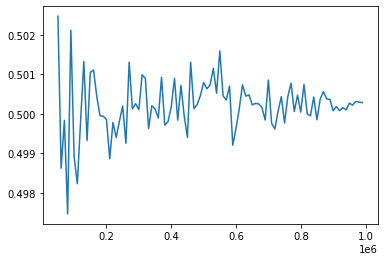

In [22]:
sns.lineplot(x = n_range[5:], y = out[5:]);

So another way to interpret the law of large numbers is that it is not that uncommon to see large variations in small samples, but those variations begin to fade away with larger and larger samples. For example, if you toss a fair coin 4 times, an outcome consisting of only heads is not that uncommon, but if you toss the coin 20 times, such an outcome would be very rare. So with large samples, the ratio of heads to number of throws approaches $50\%$ more and more.

Here's another example involving the normal distribution. Let's first generate the data:

In [23]:
start = 10
end = 10000
step = 10

norms = pd.DataFrame(columns = ['n', 'mean', 'var'], dtype = np.float32)
                      
for index, n in enumerate(range(start, end, step)):
    sample = nr.normal(size = n)
    norms.loc[index, ['n', 'mean', 'var']] = n, np.mean(sample), np.var(sample)

norms.head()

,n,mean,var
0,10.0,-0.474636,0.517334
1,20.0,-0.216220,0.617945
2,30.0,-0.081606,0.660103
3,40.0,0.165098,0.896710
4,50.0,0.052942,0.968506


Let's see how the mean of the sample converge to the population mean and the sample standard deviation converge to the population standard deviation:

In [ ]:
sns.lineplot(x = 'n', y = 'mean', data = norms);

In [ ]:
sns.lineplot(x = 'n', y = 'var', data = norms);

### Exercise



The law of large numbers should not be very surprising. After all, all it says is that as a sample gets bigger and bigger it resembles the population more and more. There is a another theorem in statistics with slightly more surprising results: The **central limit theorem (CLT)** states that if you draw samples from a population and take their average $\bar X$, then for a large enough sample size $n$, $\bar X$ is normally distributed with mean $\mu$ and variance $\sigma/n$ where $\mu$ and $\sigma$ are the populations mean and variance. In other words,

$$\text{if }\bar X = \sum_{i = 1}^n X_i \text{ , then } \bar X \sim N(\mu, \frac{\sigma^2}{n}) \text{ for large enough } n$$

What's so surprising about the CLT? It is true regardless of the distribution of X itself. That means that $X$ can have any distribution (that look nothing like the normal distribution), but with $n$ large enough $\bar X$ will follow a normal distribution. This means we can use the normal distribution to quantify our uncertainty about $\bar X$ for a given sample size.

Check if this is true by generating 100 random samples of sizes $n = 25$ from an exponential distribution with $\beta = 2/3$, which we can write as $X \sim \text{Exp}(\beta)$ and finding the sample mean each time. NOTE: The theoretical (population) mean and variance of a exponential distribution are $\beta$ and $\beta^2$ respectively. So our goal is to show $\bar X \sim N(\beta, \beta^2)$, which should look more and more so the larger $n$.

Plot the distribution of the $X$, then plot the distribution of $\bar X$. HINT: Use `sns.displot`.

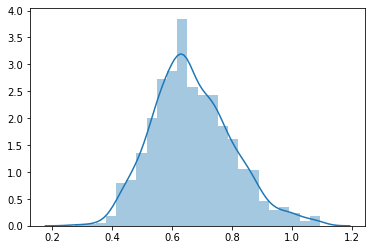

In [30]:
samples = []
for i in range(1000):
    samples.append(np.mean(nr.exponential(scale = 2/3, size = 25)))
    
df = pd.DataFrame(samples)
sns.distplot(df);


### Exercise

## Bootstrapping its relation to sampling

We learned from the central limit theorem that the **mean** of a sample of size $n$ follows a normal distributon with center $\mu$ and variance $\sigma^2 / n$ where $\mu$ and $\sigma$ are the mean and variance of the population the sample was drawn from. And more importantly, the CTL holds regardless of the distribution of the population itelf as long as the sample size is large enough. So this leads to another question? What if we wanted to estimate the distribution of *some other statistic* besides the sample mean? For example, can we draw a similar conclusion about the distribution of the **sample median**? What about the distribution of the **sample variance**? Unfortunately, the CLT only applies to the sample mean, and finding the distribution of any other statistic is not that easy, but we can use a sampling technique called **bootstrapping** to estimate such a distribution.

The sampling techniques we learned so far mainly deal with the problem of how to create smaller data in a way that it is representative of the larger population, and all of them were a form of sampling **without replacement**. **Bootstrapping** relies on sampling from data **with replacement** (which means the same row of data can end of more than once in the sampled data). Bootstrapping is useful technique when we want to estimate the distribution of a statistic that would otherwise be hard to estimate. 

Say for example that we want to estimate the distribution of the difference in the median of group 1 and group 2 in the data. Here's how we can use bootstrapping to estimate the distribution:

1. Take a bootstrap sample from the subset of data where `group` is ether 1 or 2.
1. Find the disfference between the medians of the above two samples.
1. Repeat 1-2 as many times as needed.

If we repeat the above steps $N$ times, then we end of with $N$ bootstrap estimates of the difference between the medians for group 1 vs 2. We can then plot the distribution of it. Note that to get a bootstrap sample, we just use the `sample` method with `replace = True`.

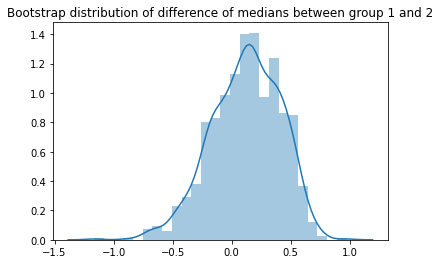

In [31]:
bootstrap_estimates = []
n_times = 1000

for i in range(n_times):
    sample = data.loc[data['group'].isin([1, 2])].sample(frac = 1.0, replace = True)
    med_1, med_2 = sample.groupby('group')['var'].median()
    bootstrap_estimates.append(med_1 - med_2)


sns.distplot(bootstrap_estimates)
plt.title("Bootstrap distribution of difference of medians between group 1 and 2");

The distribution suggests that the great majority of the time, the difference of the medians for group 1 and 2 will be somewhere between $-0.5$ and $0.5$. Notice that it is not necessary the case that the bootstrap statistics are normally distributed. In fact, if we knew what the distribution was we would not be using bootstrapping to estimate it in the first place.

## Summary

We learned about sampling in this notebook and different ways that we can sample from data. We then used **repeated sampling without replacement** to show an example of the CLT and **repeated sampling with replacement** to show how bootstrapping can be used to estimate the distribution of other statistics.